In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from load_dataset import load_titanic
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from util.utils import learning_curve_with_cross_validation
from util.utils import perform_grid_search
from util.utils import best_model_test_set_metrics 
from sklearn.tree import plot_tree
from tqdm import tqdm


# fix all random seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
df = load_titanic()
# X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, random_state=RANDOM_SEED)
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, random_state=RANDOM_SEED, shuffle=True, stratify=df['target'])
X = df.drop('target', axis=1)
y = df['target']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# X = scaler.fit_transform(X)
# X = pd.DataFrame(X, columns=df.drop('target', axis=1).columns)


X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)



# compute the weight dict for future use
weight_dict = df['target'].value_counts().to_dict()
weight_dict[0] = weight_dict[0] / weight_dict[1]
weight_dict[1] = 1.0

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
# standard scale pclass,age, sibsp, parch, fare

X_numerical = X[['pclass', 'age', 'sibsp', 'parch', 'fare']]
X_categorical = X.drop(['pclass', 'age', 'sibsp', 'parch', 'fare'], axis=1)

X_numerical = scaler.fit_transform(X_numerical)
X_numerical = pd.DataFrame(X_numerical, columns=['pclass', 'age', 'sibsp', 'parch', 'fare'])

X_scaled = pd.concat([X_numerical, X_categorical], axis=1)
X_scaled

,pclass,age,sibsp,parch,fare,alone,adult,Cherbourg,Queenstown,Southampton,female,male
0,0.908600,-0.527669,0.522511,-0.506787,-0.516380,0,1,0,0,1,0,1
1,-1.482983,0.577094,0.522511,-0.506787,0.694046,0,1,1,0,0,1,0
2,0.908600,-0.251478,-0.552714,-0.506787,-0.503620,1,1,0,0,1,1,0
3,-1.482983,0.369951,0.522511,-0.506787,0.350326,0,1,0,0,1,1,0
4,0.908600,0.369951,-0.552714,-0.506787,-0.501257,1,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
707,0.908600,0.646142,-0.552714,5.350885,-0.102875,0,1,0,1,0,1,0
708,-0.287191,-0.182430,-0.552714,-0.506787,-0.407687,1,1,0,0,1,0,1
709,-1.482983,-0.734812,-0.552714,-0.506787,-0.086335,1,1,0,0,1,1,0
710,-1.482983,-0.251478,-0.552714,-0.506787,-0.086335,1,1,1,0,0,0,1


# 1. Clustering algorithms

In [39]:
# Let's apply clustering on the dataset: Expectation Maximization and KMeans

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## 1.1 Dendrogram
Helps to visualize the clustering of the data. It is a tree-like diagram that records the sequences of merges or splits.

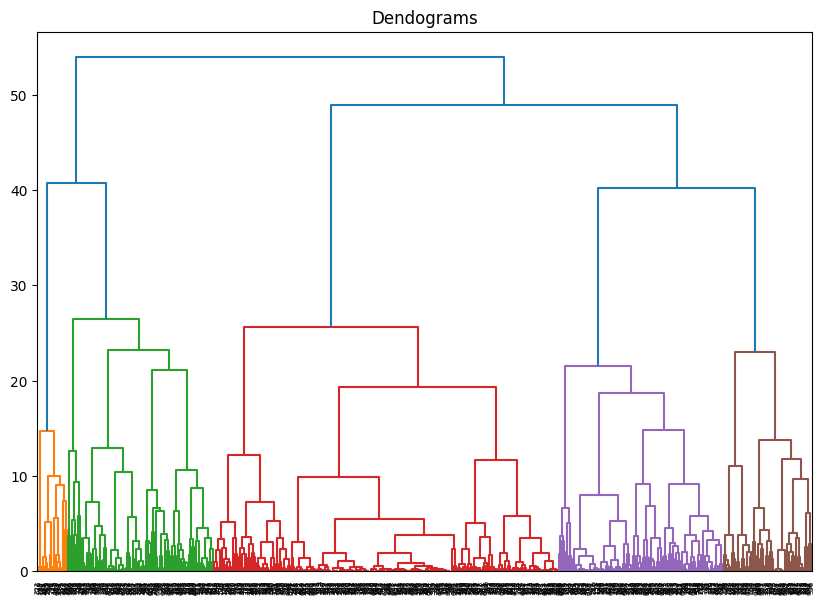

In [15]:
# first apply agglomerative clustering, visualize the hierarchy and then apply kmeans
from sklearn.cluster import AgglomerativeClustering
# visualize dendrogram
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))
plt.title("Dendograms")
dend = shc.dendrogram(shc.linkage(X, method='ward'), color_threshold=35)

## 1.2 Clustering with K-Medoids

In [69]:
from util.utils import k_medoid_multi_seed

# apply k-medoids clustering
k_medoids = k_medoid_multi_seed(X_scaled, 2, 30, metric='euclidean')

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [00:02<00:00,  9.61it/s]


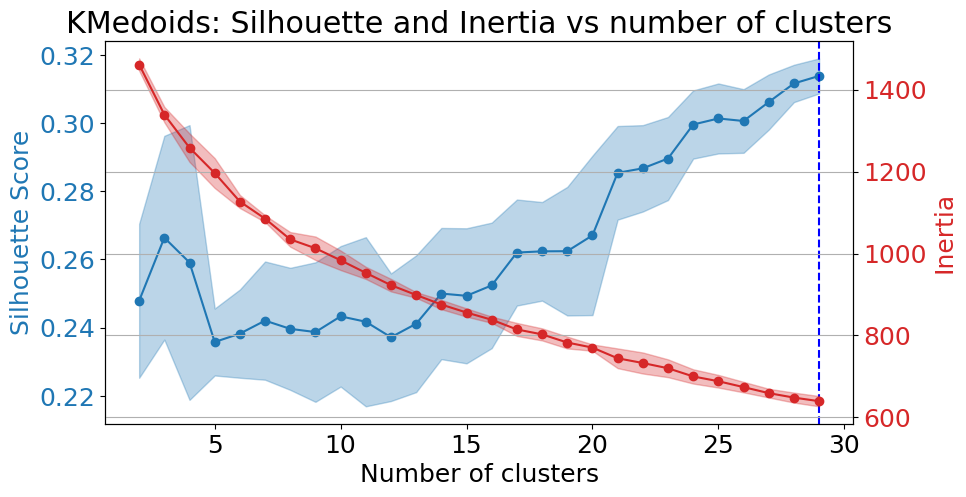

In [70]:
from util.utils import plot_k_medoid_multi_seed

plot_k_medoid_multi_seed(2, 30, "euclidean", k_medoids[0], k_medoids[1], k_medoids[2], k_medoids[3])

In [74]:
from sklearn.metrics import adjusted_rand_score
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=2, random_state=RANDOM_SEED, metric='euclidean')
kmedoids.fit(X_scaled)
labels = kmedoids.predict(X_scaled)
ari = adjusted_rand_score(y, labels)
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.0


/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


## 1.2 EM algorithm

In [53]:
# Initialize an empty list to store the silhouette scores
silhouette_scores = []
aics = []
bics = []

# Range of clusters to try
min_clusters = 2
max_clusters = 20

# Apply Gaussian Mixture Model for different number of clusters
for n_clusters in tqdm(range(min_clusters, max_clusters+1)):
    gmm = GaussianMixture(n_components=n_clusters, random_state=RANDOM_SEED, n_init=10, max_iter=1000, covariance_type='full')
    gmm.fit(X_train_scaled)
    labels = gmm.predict(X_train_scaled)
    silhouette_scores.append(silhouette_score(X_train_scaled, labels))
    aics.append(gmm.aic(X_train_scaled))
    bics.append(gmm.bic(X_train_scaled))


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:22<00:00,  1.20s/it]


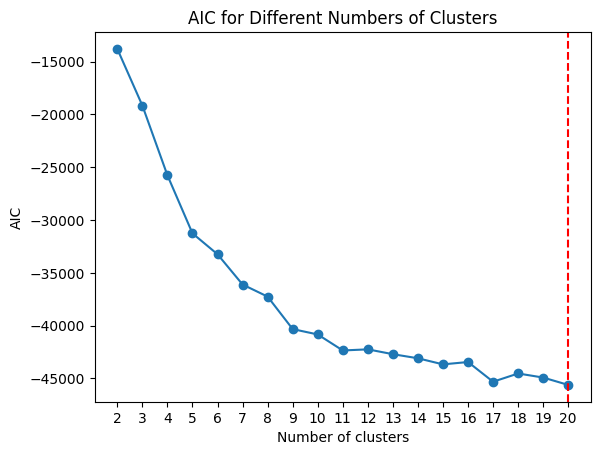

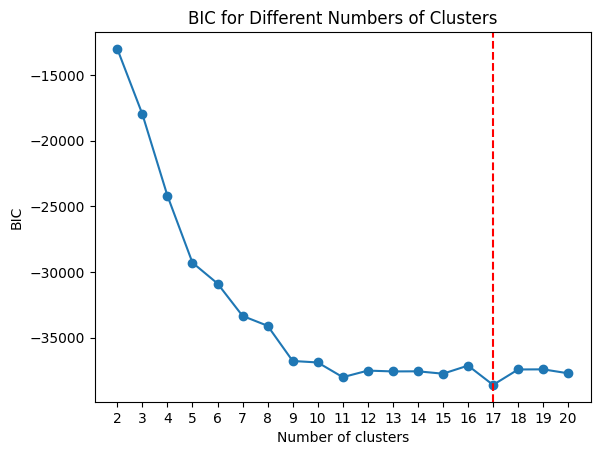

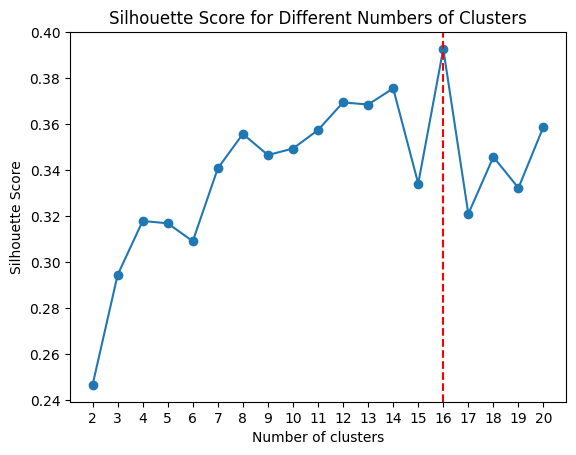

Best number of clusters according to AIC: 20
Best number of clusters according to BIC: 17
Best number of clusters according to Silhouette Score: 16


In [55]:
# Plotting the silhouette scores to find the elbow point
plt.plot(range(min_clusters, max_clusters+1), aics, marker='o')
# add vertical line at best number of clusters
plt.axvline(np.argmin(aics) + 2, color='r', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('AIC')
plt.title('AIC for Different Numbers of Clusters')
# x-axis with integer ticks
plt.xticks(range(min_clusters, max_clusters+1))
plt.show()

# Plotting the silhouette scores to find the elbow point
plt.plot(range(min_clusters, max_clusters+1), bics, marker='o')
# add vertical line at best number of clusters
plt.axvline(np.argmin(bics) + 2, color='r', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.title('BIC for Different Numbers of Clusters')
plt.xticks(range(min_clusters, max_clusters+1))
plt.show()

# Plotting the silhouette scores to find the elbow point
plt.plot(range(min_clusters, max_clusters+1), silhouette_scores, marker='o')
# add vertical line at best number of clusters
plt.axvline(np.argmax(silhouette_scores) + 2, color='r', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.xticks(range(min_clusters, max_clusters+1))
plt.show()

print('Best number of clusters according to AIC:', np.argmin(aics) + 2)
print('Best number of clusters according to BIC:', np.argmin(bics) + 2)
print('Best number of clusters according to Silhouette Score:', np.argmax(silhouette_scores) + 2)

In [65]:
# evaluate the clustering performance versus the actual labels with ARI
from sklearn.metrics import adjusted_rand_score
gmm = GaussianMixture(n_components=2, random_state=RANDOM_SEED, n_init=1, max_iter=1000, covariance_type='full')
gmm.fit(X_train_scaled)
labels = gmm.predict(X_train_scaled)
ari = adjusted_rand_score(y_train, labels)
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.20265099971767556


# 2. Dimensionality reduction algorithms

## 2.1 PCA

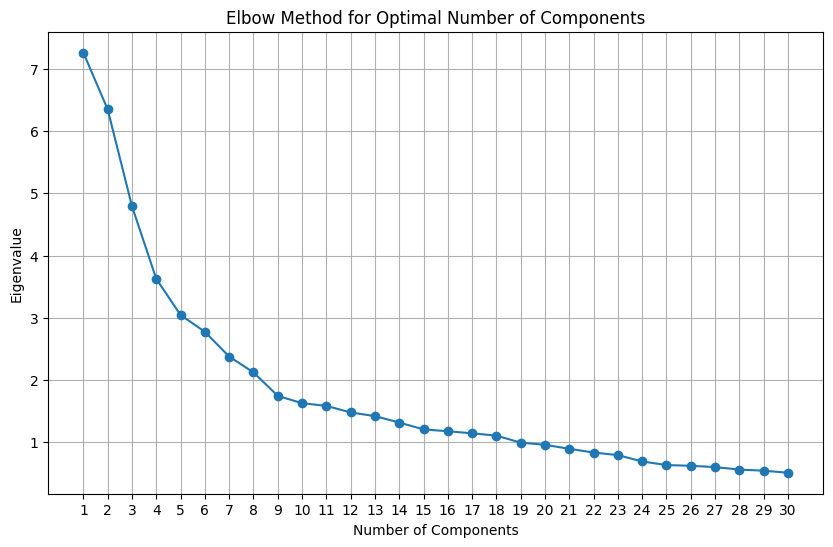

In [79]:
from sklearn.decomposition import PCA

# Initialize PCA
pca = PCA(n_components=30, random_state=RANDOM_SEED)

# Fit PCA on the scaled training data
pca.fit(X_train_scaled)

# Get eigenvalues
eigenvalues = pca.explained_variance_

plt.figure(figsize=(10, 6))
# Plot eigenvalues to visualize the explained variance
plt.plot(range(1, len(eigenvalues)+1), eigenvalues, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.title('Elbow Method for Optimal Number of Components')
# Add a gridd to the plot
plt.grid()
# x axis ticks to be integers
plt.xticks(range(1, len(eigenvalues)+1))
plt.show()

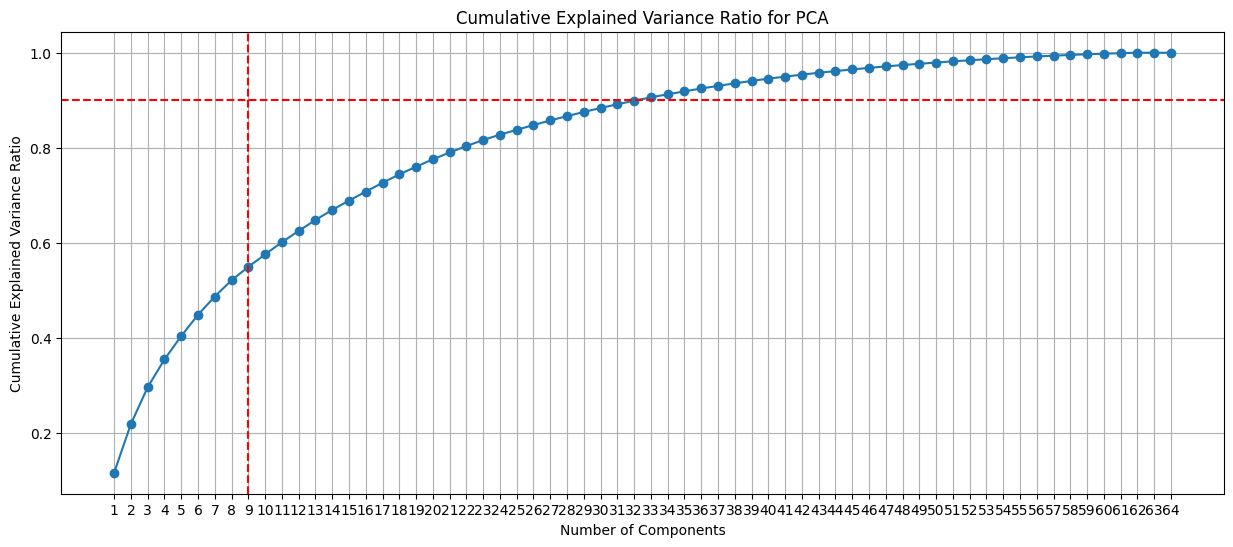

In [82]:
# Initialize PCA
pca = PCA(n_components=None, random_state=RANDOM_SEED)

# Fit PCA on the scaled training data
pca.fit(X_train_scaled)

# Get explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Compute cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(15, 6))
# Plot cumulative explained variance ratio
plt.plot(range(1, len(cumulative_variance_ratio)+1), cumulative_variance_ratio, marker='o', linestyle='-')
# add a horizontal line at y=0.90
plt.axhline(y=0.90, color='r', linestyle='--')
# add a vertical line at x=9
plt.axvline(x=9, color='r', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio for PCA')
# Add a gridd to the plot
plt.grid()
# x axis ticks to be integers
plt.xticks(range(1, len(cumulative_variance_ratio)+1))
plt.show()

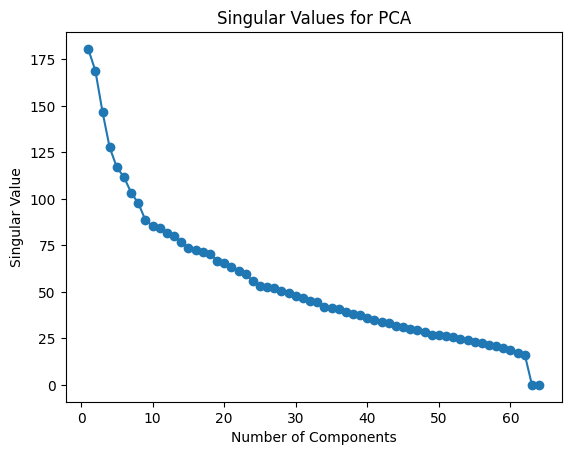

In [72]:
# analyze pca singular values
plt.plot(range(1, len(pca.singular_values_)+1), pca.singular_values_, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Singular Value')
plt.title('Singular Values for PCA')
plt.show()

## 2.2 ICA

  0%|          | 0/58 [00:00<?, ?it/s]

  3%|▎         | 2/58 [00:00<00:05,  9.76it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
 36%|███▌      | 21/58 [00:01<00:02, 14.46it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
 40%|███▉      | 23/58 [00:01<00:04,  7.64it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing toleranc

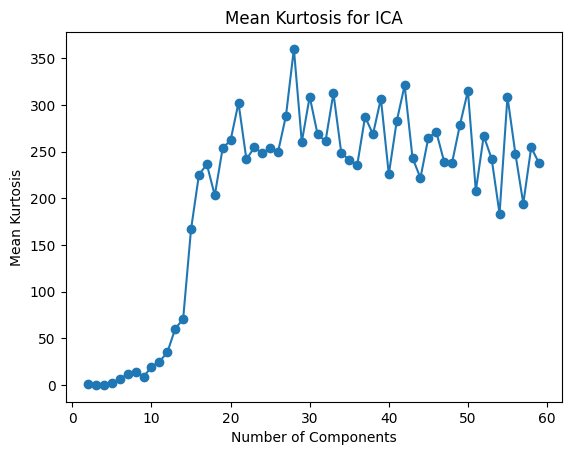

In [83]:
from sklearn.decomposition import FastICA
from scipy.stats import kurtosis

# loop through different number of components and compute mean kurtosis
kurtosis_ = []
n_components = range(2, 60)

for n in tqdm(n_components):
    ica = FastICA(n_components=n, random_state=RANDOM_SEED)
    X_train_ica = ica.fit_transform(X_train_scaled)
    kurtosis_.append(np.mean(kurtosis(X_train_ica)))

plt.plot(n_components, kurtosis_, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Mean Kurtosis')
plt.title('Mean Kurtosis for ICA')
plt.show()



## 2.3 Randomized Projections

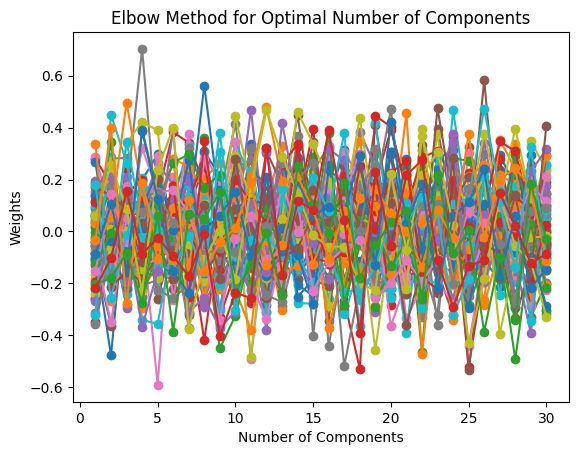

In [67]:
from sklearn.random_projection import GaussianRandomProjection

# Initialize Random Projection
grp = GaussianRandomProjection(n_components=30, random_state=RANDOM_SEED)

# Fit Random Projection on the scaled training data
grp.fit(X_train_scaled)

# Get weights
weights = grp.components_

# Plot weights to visualize the explained variance
plt.plot(range(1, len(weights)+1), weights, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Weights')
plt.title('Elbow Method for Optimal Number of Components')
plt.show()

## 2.4 t-SNE

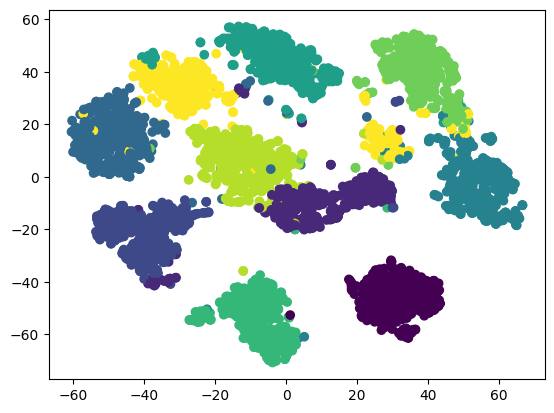

In [68]:
from sklearn.manifold import TSNE

# Initialize TSNE
tsne = TSNE(n_components=2, random_state=RANDOM_SEED)

# Fit TSNE on the scaled training data
X_train_tsne = tsne.fit_transform(X_train_scaled)

# Plot TSNE
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis')

